In this fusion method, rfc, lgbm and xgb models' prediction results are voted. Thus, implementing a late fusion technique.

In [1]:
import os
import ast
import h5py
import pandas as pd
import geopandas as gpd

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

In [2]:
input_file = "data/combined_data.geojson"
## Read combined data
combined_gdf = gpd.read_file(input_file)

In [3]:
print(combined_gdf.head())
print(combined_gdf.crs)
print(combined_gdf.columns.to_list())
combined_gdf.crs = "EPSG:25832"
print(combined_gdf.crs)
print(combined_gdf.shape)

                     id                                                B11  \
0  0000000000000000050b  [ [ 0.23570001125335693, 0.23570001125335693, ...   
1  0000000000000000050c  [ [ 0.31589999794960022, 0.31589999794960022, ...   
2  0000000000000000050d  [ [ 0.19909998774528503, 0.18310000002384186, ...   
3  0000000000000000050e  [ [ 0.22779999673366547, 0.22419999539852142, ...   
4  0000000000000000050f  [ [ 0.25600001215934753, 0.26150000095367432, ...   

                                               B11_1  \
0                                               None   
1  [ [ 0.33454999327659607, 0.33454999327659607, ...   
2  [ [ 0.25055000185966492, 0.2463500052690506, 0...   
3  [ [ 0.26010000705718994, 0.25749999284744263, ...   
4  [ [ 0.28685000538825989, 0.29079997539520264, ...   

                                               B11_2  \
0  [ [ 0.25260001420974731, 0.25260001420974731, ...   
1  [ [ 0.36035001277923584, 0.36035001277923584, ...   
2  [ [ 0.33680000901222229

In [4]:
# for now, we just select the NDVI, and keep id&species
select_col = ['l1_leaf_types', 'l2_genus','l3_species', 'EVI', 'EVI2', 'EVI2_1', 'EVI2_2', 'EVI2_3', 'EVI2_4', 'EVI2_5', 'EVI2_6', 'EVI2_7', 'EVI_1', 'EVI_2', 'EVI_3', 'EVI_4', 'EVI_5', 'EVI_6', 'EVI_7','NDVI', 'NDVI_1', 'NDVI_2', 'NDVI_3', 'NDVI_4', 'NDVI_5', 'NDVI_6', 'NDVI_7', 'NDWI', 'NDWI_1', 'NDWI_2', 'NDWI_3', 'NDWI_4', 'NDWI_5', 'NDWI_6', 'NDWI_7', 'SAVI', 'SAVI_1', 'SAVI_2', 'SAVI_3', 'SAVI_4', 'SAVI_5', 'SAVI_6', 'SAVI_7']

select_df = combined_gdf[select_col]

In [5]:
# for now we just dorp the None
combined_gdf_cleaned = select_df.dropna().reset_index(drop=True)
print(combined_gdf_cleaned.shape)
print(combined_gdf_cleaned.isnull().any())

(26268, 43)
l1_leaf_types    False
l2_genus         False
l3_species       False
EVI              False
EVI2             False
EVI2_1           False
EVI2_2           False
EVI2_3           False
EVI2_4           False
EVI2_5           False
EVI2_6           False
EVI2_7           False
EVI_1            False
EVI_2            False
EVI_3            False
EVI_4            False
EVI_5            False
EVI_6            False
EVI_7            False
NDVI             False
NDVI_1           False
NDVI_2           False
NDVI_3           False
NDVI_4           False
NDVI_5           False
NDVI_6           False
NDVI_7           False
NDWI             False
NDWI_1           False
NDWI_2           False
NDWI_3           False
NDWI_4           False
NDWI_5           False
NDWI_6           False
NDWI_7           False
SAVI             False
SAVI_1           False
SAVI_2           False
SAVI_3           False
SAVI_4           False
SAVI_5           False
SAVI_6           False
SAVI_7           False

In [6]:
# load the labels
labels = np.array(combined_gdf_cleaned[['l1_leaf_types', 'l2_genus','l3_species']])
sen2 = np.array(combined_gdf_cleaned[['EVI', 'EVI2', 'EVI2_1', 'EVI2_2', 'EVI2_3', 'EVI2_4', 'EVI2_5', 'EVI2_6', 'EVI2_7', 'EVI_1', 'EVI_2', 'EVI_3', 'EVI_4', 'EVI_5', 'EVI_6', 'EVI_7','NDVI', 'NDVI_1', 'NDVI_2', 'NDVI_3', 'NDVI_4', 'NDVI_5', 'NDVI_6', 'NDVI_7', 'NDWI', 'NDWI_1', 'NDWI_2', 'NDWI_3', 'NDWI_4', 'NDWI_5', 'NDWI_6', 'NDWI_7', 'SAVI', 'SAVI_1', 'SAVI_2', 'SAVI_3', 'SAVI_4', 'SAVI_5', 'SAVI_6', 'SAVI_7']])
# show the shape
print("Labels shape: " + str(labels.shape))
#print("Sen2 shape: " + str(sen2.shape))

# print the labels
print(labels[:])
print(sen2[:])
print(sen2.shape)

Labels shape: (26268, 3)
[['broadleaf' 'beech' 'european beech']
 ['broadleaf' 'beech' 'european beech']
 ['broadleaf' 'beech' 'european beech']
 ...
 ['needleleaf' 'pine' 'scots pine']
 ['needleleaf' 'pine' 'scots pine']
 ['needleleaf' 'pine' 'scots pine']]
[['[ [ 0.20749008911810152, 0.20749008911810152, 0.19399448468637809, 0.19399448468637809, 0.17264941854954027 ], [ 0.18811365650919964, 0.18811365650919964, 0.1849789855605749, 0.1849789855605749, 0.16339870893377503 ], [ 0.15306353645981172, 0.17718141664517226, 0.21298995013305966, 0.21298995013305966, 0.1739566666446915 ], [ 0.19121085741222177, 0.2207476943381205, 0.22820864778601127, 0.22820864778601127, 0.18666553060357882 ], [ 0.28203077196510823, 0.27142411560406604, 0.2212287710345307, 0.2212287710345307, 0.18814043369977704 ] ]'
  '[ [ 0.14782237840573534, 0.14782237840573534, 0.14476302135383265, 0.14476302135383265, 0.12484099071992923 ], [ 0.13129488527943947, 0.13129488527943947, 0.13603209468360802, 0.13603209468360

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
Unique species in first 19 samples:
['broadleaf']

All unique species:
['broadleaf' 'needleleaf']

Species distribution:
l1_leaf_types
broadleaf     14110
needleleaf    12158
Name: count, dtype: int64


(array([14110.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
        12158.]),
 array([0.        , 0.05882353, 0.11764706, 0.17647059, 0.23529412,
        0.29411765, 0.35294118, 0.41176471, 0.47058824, 0.52941176,
        0.58823529, 0.64705882, 0.70588235, 0.76470588, 0.82352941,
        0.88235294, 0.94117647, 1.        ]),
 <BarContainer object of 17 artists>)

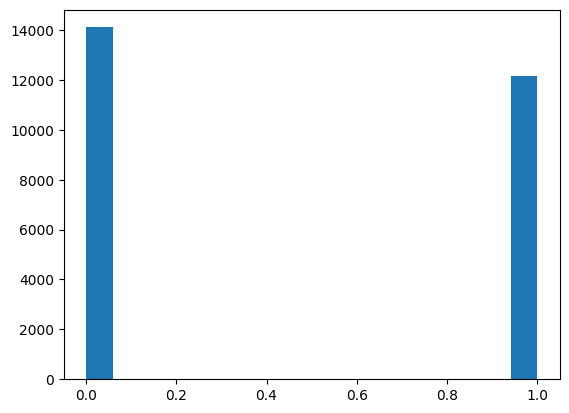

In [7]:
labels_raw = np.array(combined_gdf_cleaned['l1_leaf_types'])
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
labels_l1 = encoder.fit_transform(labels_raw.reshape(-1, 1))
#print("Labels shape: " + str(labels.shape))
#print("\nFirst 19 rows:")
print(labels_l1[:10])

print("Unique species in first 19 samples:")
print(combined_gdf_cleaned['l1_leaf_types'][:19].unique())

print("\nAll unique species:")
print(combined_gdf_cleaned['l1_leaf_types'].unique())

print("\nSpecies distribution:")
print(combined_gdf_cleaned['l1_leaf_types'].value_counts())

# Check the data distribution
plt.hist(np.argmax(labels_l1, axis=1), bins=17)

[[1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]]
Unique species in first 19 samples:
['beech']

All unique species:
['beech' 'long-lived deciduous' 'oak' 'short-lived deciduous'
 'douglas fir' 'fir' 'larch' 'pine' 'spruce']

Species distribution:
l2_genus
pine                     5012
oak                      4531
short-lived deciduous    3485
spruce                   3107
long-lived deciduous     3105
beech                    2989
larch                    1884
douglas fir              1657
fir                       498
Name: count, dtype: int64


(array([2989.,    0., 1657.,    0.,  498.,    0., 1884.,    0., 3105.,
           0., 4531.,    0., 5012.,    0., 3485.,    0., 3107.]),
 array([0.        , 0.47058824, 0.94117647, 1.41176471, 1.88235294,
        2.35294118, 2.82352941, 3.29411765, 3.76470588, 4.23529412,
        4.70588235, 5.17647059, 5.64705882, 6.11764706, 6.58823529,
        7.05882353, 7.52941176, 8.        ]),
 <BarContainer object of 17 artists>)

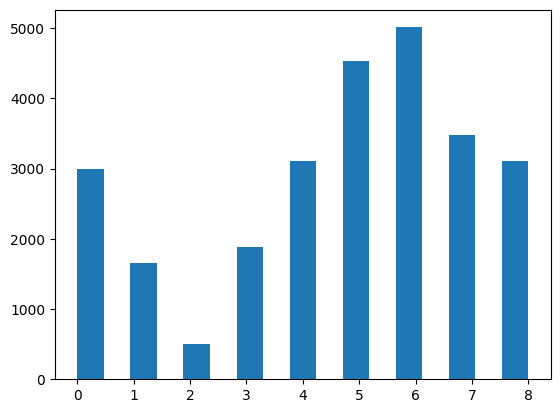

In [8]:
labels_raw = np.array(combined_gdf_cleaned['l2_genus'])
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
labels_l2 = encoder.fit_transform(labels_raw.reshape(-1, 1))
#print("Labels shape: " + str(labels.shape))
#print("\nFirst 19 rows:")
print(labels_l2[:10])

print("Unique species in first 19 samples:")
print(combined_gdf_cleaned['l2_genus'][:19].unique())

print("\nAll unique species:")
print(combined_gdf_cleaned['l2_genus'].unique())

print("\nSpecies distribution:")
print(combined_gdf_cleaned['l2_genus'].value_counts())

# Check the data distribution
plt.hist(np.argmax(labels_l2, axis=1), bins=17)

In [35]:
# Print Sentinel-2 data
print("Sentinel-2 shape: " + str(sen2.shape))
sen2_depot = sen2 # so that I dont need to rerun the whole thing

Sentinel-2 shape: (26268, 40)


In [36]:
# Convert string representation of arrays to actual numpy arrays
def convert_string_to_array(s):
	# Using ast.literal_eval to safely evaluate the string as a Python literal
	array_data = ast.literal_eval(s)
	return np.array(array_data)

# Convert all elements in sen2 to numpy arrays
sen2_arrays = np.array([convert_string_to_array(x) for x in sen2.flatten()])
number_samples = sen2.shape[0]
sen2_reshaped = sen2_arrays.reshape(number_samples, -1)

print("Post-processed Sentinel-2 data shape: ", sen2_reshaped.shape)

print("Post-processed Sentinel-2 data:", type(sen2_reshaped[0][0]))
print(sen2_reshaped[0].shape)

Post-processed Sentinel-2 data shape:  (26268, 1000)
Post-processed Sentinel-2 data: <class 'numpy.float64'>
(1000,)


In [37]:
combined_gdf_cleaned.columns.to_list()

['l1_leaf_types',
 'l2_genus',
 'l3_species',
 'EVI',
 'EVI2',
 'EVI2_1',
 'EVI2_2',
 'EVI2_3',
 'EVI2_4',
 'EVI2_5',
 'EVI2_6',
 'EVI2_7',
 'EVI_1',
 'EVI_2',
 'EVI_3',
 'EVI_4',
 'EVI_5',
 'EVI_6',
 'EVI_7',
 'NDVI',
 'NDVI_1',
 'NDVI_2',
 'NDVI_3',
 'NDVI_4',
 'NDVI_5',
 'NDVI_6',
 'NDVI_7',
 'NDWI',
 'NDWI_1',
 'NDWI_2',
 'NDWI_3',
 'NDWI_4',
 'NDWI_5',
 'NDWI_6',
 'NDWI_7',
 'SAVI',
 'SAVI_1',
 'SAVI_2',
 'SAVI_3',
 'SAVI_4',
 'SAVI_5',
 'SAVI_6',
 'SAVI_7']

In [61]:
X = sen2_reshaped
print(X.shape)
TRAIN_SPLIT = int(number_samples * .8)

X_train = X[:TRAIN_SPLIT,:]
X_test = X[TRAIN_SPLIT:,:]

(26268, 1000)


In [39]:
y_train_l1 = np.argmax(labels_l1[0:TRAIN_SPLIT,:], axis=1)
y_test_l1 = np.argmax(labels_l1[TRAIN_SPLIT:26268,:], axis=1)

print("Post-processed train labels shape: ", y_train_l1.shape)

Post-processed train labels shape:  (21014,)


Accuracies:  [0.9183203401842664, 0.9163713678242381, 0.9213323883770376, 0.9165485471296952, 0.9220411055988661]
Mean Accuracy:  0.9189227498228206
F1 Scores:  [0.9183131369100526, 0.9163671671134674, 0.9213311930853061, 0.9165477900150018, 0.9220371896820458]
Mean F1 Score:  0.9189192953611748


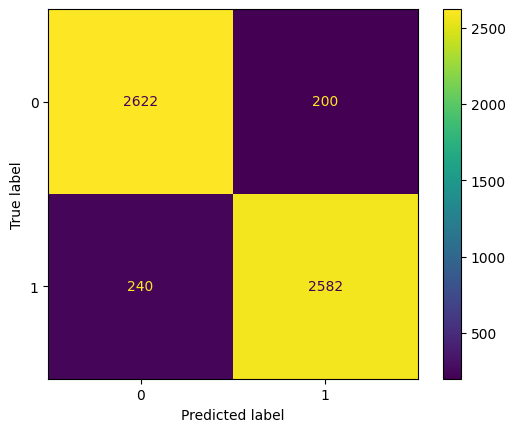

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
import numpy as np

import matplotlib.pyplot as plt

# Apply SMOTE to balance the classes
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train_l1)

# Initialize Stratified K-Fold
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

# Arrays to store the results
accuracies = []
f1_scores = []
confusion_matrices = []

# Perform Stratified K-Fold Cross-Validation
for train_index, test_index in skf.split(X_resampled, y_resampled):
    X_train, X_test = X_resampled[train_index], X_resampled[test_index]
    y_train, y_test = y_resampled[train_index], y_resampled[test_index]
    
    # Train the Random Forest Classifier
    rf_classifier = RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced')
    rf_classifier.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = rf_classifier.predict(X_test)
    
    # Calculate accuracy and F1 score
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Store the results
    accuracies.append(acc)
    f1_scores.append(f1)
    confusion_matrices.append(confusion_matrix(y_test, y_pred))

# Display the results
print("Accuracies: ", accuracies)
print("Mean Accuracy: ", np.mean(accuracies))
print("F1 Scores: ", f1_scores)
print("Mean F1 Score: ", np.mean(f1_scores))

# Display the confusion matrix for the last fold
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

In [70]:
sen2_l1_fus = np.array(combined_gdf_cleaned[['EVI', 'EVI2', 'EVI2_1', 'EVI2_2', 'EVI2_3', 'EVI2_4', 'EVI2_5', 'EVI2_6', 'EVI2_7', 'EVI_1', 'EVI_2', 'EVI_3', 'EVI_4', 'EVI_5', 'EVI_6', 'EVI_7','NDVI', 'NDVI_1', 'NDVI_2', 'NDVI_3', 'NDVI_4', 'NDVI_5', 'NDVI_6', 'NDVI_7', 'NDWI', 'NDWI_1', 'NDWI_2', 'NDWI_3', 'NDWI_4', 'NDWI_5', 'NDWI_6', 'NDWI_7', 'SAVI', 'SAVI_1', 'SAVI_2', 'SAVI_3', 'SAVI_4', 'SAVI_5', 'SAVI_6', 'SAVI_7', 'l1_leaf_types']])
print(sen2_l1_fus.shape)

(26268, 41)


In [71]:
# Convert string representation of arrays to actual numpy arrays
def convert_string_to_array(s):
	if isinstance(s, str):
		# Using ast.literal_eval to safely evaluate the string as a Python literal
		try:
			array_data = ast.literal_eval(s)
			return np.array(array_data).flatten()
		except:
			return np.array([])
	elif isinstance(s, (list, np.ndarray)):
		return np.array(s).flatten()
	else:
		return np.array([s])

# Process each row separately
processed_arrays = []
for row in sen2_l1_fus:
	# Convert each element in the row
	row_arrays = [convert_string_to_array(x) for x in row[:-1]]  # Exclude the last column (labels)
	# Concatenate all arrays in the row
	processed_arrays.append(np.concatenate(row_arrays))

# Convert to numpy array
sen2_l1_fus_reshaped = np.array(processed_arrays)
number_samples = sen2_l1_fus.shape[0]

print("Post-processed Sentinel-2 data shape: ", sen2_l1_fus_reshaped.shape)
print("Post-processed Sentinel-2 data:", type(sen2_l1_fus_reshaped[0][0]))
print(sen2_l1_fus_reshaped[0].shape)

Post-processed Sentinel-2 data shape:  (26268, 1000)
Post-processed Sentinel-2 data: <class 'numpy.float64'>
(1000,)


(26268, 9)


(array([2989.,    0., 1657.,    0.,  498.,    0., 1884.,    0., 3105.,
           0., 4531.,    0., 5012.,    0., 3485.,    0., 3107.]),
 array([0.        , 0.47058824, 0.94117647, 1.41176471, 1.88235294,
        2.35294118, 2.82352941, 3.29411765, 3.76470588, 4.23529412,
        4.70588235, 5.17647059, 5.64705882, 6.11764706, 6.58823529,
        7.05882353, 7.52941176, 8.        ]),
 <BarContainer object of 17 artists>)

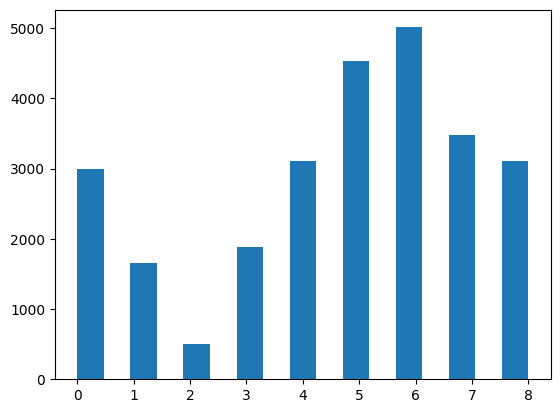

In [72]:
print(labels_l2.shape)
# Check the data distribution
plt.hist(np.argmax(labels_l2, axis=1), bins=17)

(array([5000.,    0., 5000.,    0., 5000.,    0., 5000.,    0., 6000.,
           0., 7000.,    0., 5012.,    0., 7000.,    0., 5000.]),
 array([0.        , 0.47058824, 0.94117647, 1.41176471, 1.88235294,
        2.35294118, 2.82352941, 3.29411765, 3.76470588, 4.23529412,
        4.70588235, 5.17647059, 5.64705882, 6.11764706, 6.58823529,
        7.05882353, 7.52941176, 8.        ]),
 <BarContainer object of 17 artists>)

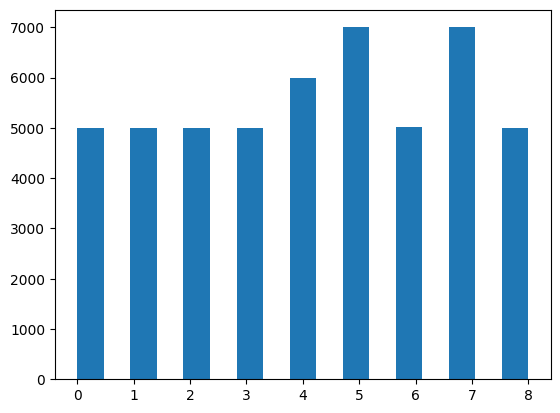

In [73]:
from imblearn.over_sampling import SMOTE

# Create a dictionary for multiple classes
sampling_strategy = {
    0: 5000,
    1: 5000,
    2: 5000,  # Keep current strategy for class 2
    3: 5000,
    7: 7000,  # Add sampling for worst performing class (F1: 0.4754)
    4: 6000,   # Add sampling for class with declining performance
    8: 5000,
    5: 7000
}

smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X_l1_fuse_resampled, y_resampled = smote.fit_resample(sen2_l1_fus_reshaped, np.argmax(labels_l2, axis=1))

# Update the labels_l2 with the resampled data
labels_l2_resampled = encoder.fit_transform(y_resampled.reshape(-1, 1))

# Check the data distribution
plt.hist(np.argmax(labels_l2_resampled, axis=1), bins=17)

In [ ]:
# Get the number of samples
n_samples = X_resampled.shape[0]

# Calculate the number of channels/features (m)
# Since each sample has a 5x5 grid, m = 1000 / (5*5) = 40
m_channels = X_resampled.shape[1] // (5 * 5)

# Reshape the data to (n_samples, 5, 5, m_channels)
X_reshaped = X_resampled.reshape(n_samples, 5, 5, m_channels)

print(f"Reshaped data dimensions: {X_reshaped.shape}")

In [78]:
print(X_l1_fuse_resampled.shape)
labels_l2_resampled.shape

(50012, 1000)


(50012, 9)

In [80]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_l1_fuse_resampled, 
    np.argmax(labels_l2_resampled, axis=1),
    test_size=0.2, 
    random_state=42,
    stratify=np.argmax(labels_l2_resampled, axis=1)
)

# Create base classifiers
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
xgb = XGBClassifier(n_estimators=200, random_state=42, n_jobs=-1)
lgbm = LGBMClassifier(n_estimators=200, random_state=42, n_jobs=-1)

# Create voting classifier
ensemble = VotingClassifier(
    estimators=[
        ('rf', rf),
        ('xgb', xgb),
        ('lgbm', lgbm)
    ],
    voting='soft'
)

# Train the ensemble
ensemble.fit(X_train, y_train)

# Make predictions
y_pred = ensemble.predict(X_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Store training and validation metrics
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

# Track individual classifier performance
rf_train_pred = rf.predict(X_train)
rf_test_pred = rf.predict(X_test)
xgb_train_pred = xgb.predict(X_train)
xgb_test_pred = xgb.predict(X_test)
lgbm_train_pred = lgbm.predict(X_train)
lgbm_test_pred = lgbm.predict(X_test)

# Calculate training and validation metrics for each classifier
print("\nRandom Forest Performance:")
print("Training Accuracy:", accuracy_score(y_train, rf_train_pred))
print("Validation Accuracy:", accuracy_score(y_test, rf_test_pred))

print("\nXGBoost Performance:")
print("Training Accuracy:", accuracy_score(y_train, xgb_train_pred))
print("Validation Accuracy:", accuracy_score(y_test, xgb_test_pred))

print("\nLightGBM Performance:")
print("Training Accuracy:", accuracy_score(y_train, lgbm_train_pred))
print("Validation Accuracy:", accuracy_score(y_test, lgbm_test_pred))

# Plot learning curves
plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.plot([accuracy_score(y_train, rf_train_pred), 
          accuracy_score(y_train, xgb_train_pred),
          accuracy_score(y_train, lgbm_train_pred)], 
         label='Training Accuracy')
plt.plot([accuracy_score(y_test, rf_test_pred),
          accuracy_score(y_test, xgb_test_pred),
          accuracy_score(y_test, lgbm_test_pred)],
         label='Validation Accuracy')
plt.xticks([0, 1, 2], ['RF', 'XGB', 'LGBM'])
plt.legend()
plt.title('Model Comparison')
plt.grid(True)

plt.tight_layout()
plt.show()


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.457651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255000
[LightGBM] [Info] Number of data points in the train set: 40009, number of used features: 1000
[LightGBM] [Info] Start training from score -2.302810
[LightGBM] [Info] Start training from score -2.302810
[LightGBM] [Info] Start training from score -2.302810
[LightGBM] [Info] Start training from score -2.302810
[LightGBM] [Info] Start training from score -2.120489
[LightGBM] [Info] Start training from score -1.966338
[LightGBM] [Info] Start training from score -2.300563
[LightGBM] [Info] Start training from score -1.966338
[LightGBM] [Info] Start training from score -2.302810
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.87      0.87      1000
           1       0.95      0.93      0.94      1000
           2       0.97      0.99  

NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [81]:
from sklearn.model_selection import StratifiedKFold, learning_curve
def plot_learning_curves(estimator, X, y):
    train_sizes = np.linspace(0.1, 1.0, 10)
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y,
        train_sizes=train_sizes,
        cv=5,
        scoring='f1_weighted',
        n_jobs=-1
    )
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Training score', color='blue')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
    plt.plot(train_sizes, val_mean, label='Cross-validation score', color='red')
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')
    
    plt.xlabel('Training Examples')
    plt.ylabel('F1 Score')
    plt.title('Learning Curves')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

In [84]:
import time
from sklearn.model_selection import GridSearchCV

# Add timing
start_time = time.time()

# Define parameter grid for tree classification
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 12, 15],
    'min_samples_split': [10, 12, 15, 20],
    'min_samples_leaf': [4, 6, 8],
    'max_features': ['sqrt', 'log2']
}

# Initialize base classifier
rf_base = RandomForestClassifier(
    random_state=42,
    n_jobs=-1
)

# Perform grid search
grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=3,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=2
)

# Print execution time
print(f"Execution time: {time.time() - start_time:.2f} seconds")
# Fit grid search
grid_search.fit(X_l1_fuse_resampled, np.argmax(labels_l2_resampled, axis=1))

# Get best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

Execution time: 0.11 seconds
Fitting 3 folds for each of 216 candidates, totalling 648 fits


c:\Users\berky\.conda\envs\dseo\lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}


Best parameters: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}


Fold 1
Fold 1 Training Accuracy: 0.9782
Fold 1 Validation Accuracy: 0.8234
Fold 1 Training Weighted F1: 0.9782
Fold 1 Validation Weighted F1: 0.8236
Per-class F1 scores: {0: '0.8039', 1: '0.8830', 2: '0.9518', 3: '0.8751', 4: '0.8244', 5: '0.7943', 6: '0.7984', 7: '0.7302', 8: '0.8000'}

Fold 2
Fold 2 Training Accuracy: 0.9787
Fold 2 Validation Accuracy: 0.8152
Fold 2 Training Weighted F1: 0.9787
Fold 2 Validation Weighted F1: 0.8154
Per-class F1 scores: {0: '0.7874', 1: '0.8879', 2: '0.9452', 3: '0.8677', 4: '0.8018', 5: '0.7907', 6: '0.7998', 7: '0.7075', 8: '0.8063'}

Fold 3
Fold 3 Training Accuracy: 0.9783
Fold 3 Validation Accuracy: 0.8182
Fold 3 Training Weighted F1: 0.9783
Fold 3 Validation Weighted F1: 0.8184
Per-class F1 scores: {0: '0.7929', 1: '0.8883', 2: '0.9602', 3: '0.8692', 4: '0.7940', 5: '0.7809', 6: '0.7971', 7: '0.7277', 8: '0.8116'}

Fold 4
Fold 4 Training Accuracy: 0.9776
Fold 4 Validation Accuracy: 0.8126
Fold 4 Training Weighted F1: 0.9775
Fold 4 Validation Wei

<Figure size 1000x800 with 0 Axes>

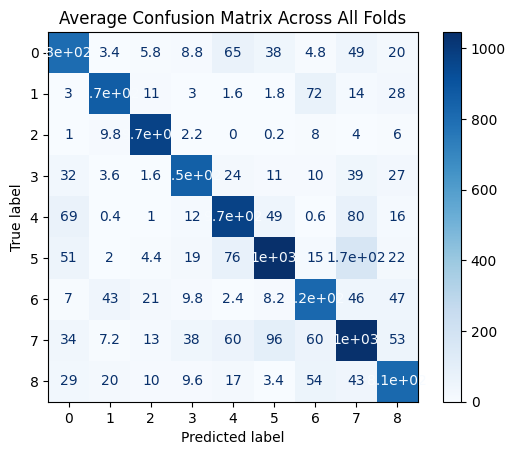

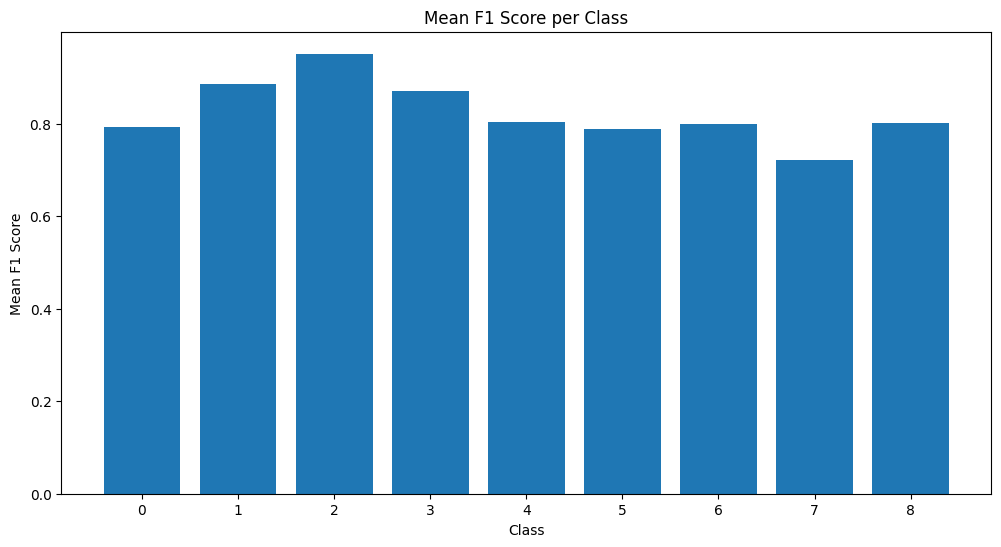

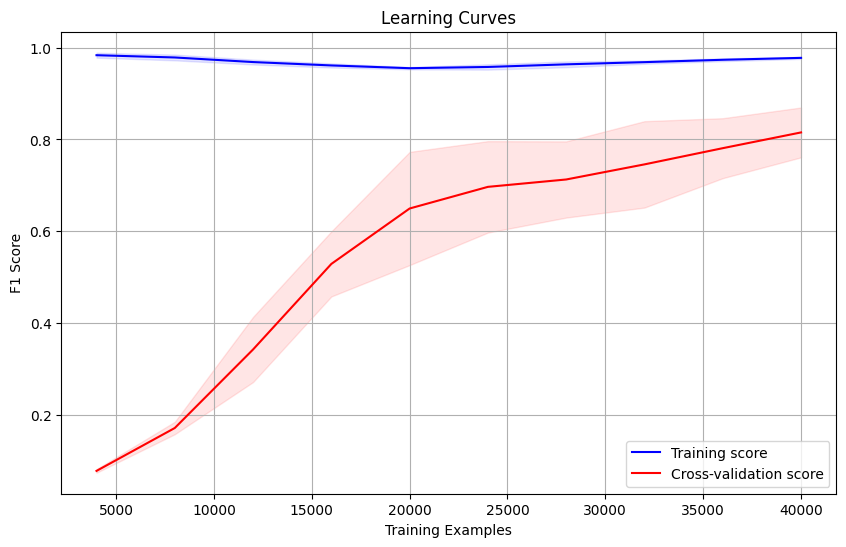

In [83]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV




# Initialize Stratified K-Fold
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

# Arrays to store the results
train_accuracies = []
val_accuracies = []
train_f1_scores = []
val_f1_scores = []
confusion_matrices = []
per_class_f1 = []  # Add per-class metrics

# Perform Stratified K-Fold Cross-Validation
for fold, (train_index, test_index) in enumerate(skf.split(X_l1_fuse_resampled, np.argmax(labels_l2_resampled, axis=1)), 1):
    print(f"\nFold {fold}")
    
    X_train, X_test = X_l1_fuse_resampled[train_index], X_l1_fuse_resampled[test_index]
    y_train, y_test = np.argmax(labels_l2_resampled[train_index], axis=1), np.argmax(labels_l2_resampled[test_index], axis=1)
    
    # Train the Random Forest Classifier with regularization
    rf_classifier = RandomForestClassifier(
    random_state=42,
    n_estimators=best_params['n_estimators'],
    criterion=best_params['criterion'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    max_features=best_params['max_features'],
    n_jobs=-1
)
    rf_classifier.fit(X_train, y_train)
    
    # Predict on the training set
    y_train_pred = rf_classifier.predict(X_train)
    
    # Predict on the test set
    y_pred = rf_classifier.predict(X_test)
    
    # Calculate metrics for training set
    train_acc = accuracy_score(y_train, y_train_pred)
    train_f1_weighted = f1_score(y_train, y_train_pred, average='weighted')
    
    # Calculate metrics for test set
    val_acc = accuracy_score(y_test, y_pred)
    val_f1_weighted = f1_score(y_test, y_pred, average='weighted')
    f1_per_class = f1_score(y_test, y_pred, average=None)
    
    # Store the results
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    train_f1_scores.append(train_f1_weighted)
    val_f1_scores.append(val_f1_weighted)
    confusion_matrices.append(confusion_matrix(y_test, y_pred))
    per_class_f1.append(f1_per_class)
    
    # Print fold results
    print(f"Fold {fold} Training Accuracy: {train_acc:.4f}")
    print(f"Fold {fold} Validation Accuracy: {val_acc:.4f}")
    print(f"Fold {fold} Training Weighted F1: {train_f1_weighted:.4f}")
    print(f"Fold {fold} Validation Weighted F1: {val_f1_weighted:.4f}")
    print("Per-class F1 scores:", {i: f"{score:.4f}" for i, score in enumerate(f1_per_class)})

# Calculate and display final results
print("\nFinal Results:")
print(f"Mean Training Accuracy: {np.mean(train_accuracies):.4f} (±{np.std(train_accuracies):.4f})")
print(f"Mean Validation Accuracy: {np.mean(val_accuracies):.4f} (±{np.std(val_accuracies):.4f})")
print(f"Mean Training Weighted F1: {np.mean(train_f1_scores):.4f} (±{np.std(train_f1_scores):.4f})")
print(f"Mean Validation Weighted F1: {np.mean(val_f1_scores):.4f} (±{np.std(val_f1_scores):.4f})")

# Calculate mean per-class F1 scores
mean_per_class_f1 = np.mean(per_class_f1, axis=0)
print("\nMean F1 score per class:")
for class_idx, f1 in enumerate(mean_per_class_f1):
    print(f"Class {class_idx}: {f1:.4f}")

# Plot confusion matrix (average across all folds)
plt.figure(figsize=(10, 8))
mean_cm = np.mean(confusion_matrices, axis=0)
ConfusionMatrixDisplay(
    confusion_matrix=mean_cm,
    display_labels=range(len(mean_per_class_f1))
).plot(cmap='Blues')
plt.title('Average Confusion Matrix Across All Folds')
plt.show()

# Plot F1 scores per class
plt.figure(figsize=(12, 6))
plt.bar(range(len(mean_per_class_f1)), mean_per_class_f1)
plt.xlabel('Class')
plt.ylabel('Mean F1 Score')
plt.title('Mean F1 Score per Class')
plt.xticks(range(len(mean_per_class_f1)))
plt.show()

plot_learning_curves(
    rf_classifier,
    X_resampled,
    np.argmax(labels_l2_resampled, axis=1)
)